In [3]:
from pathlib import Path
import glob
import exiftool
import soundfile as sf

In [17]:
import numpy as np
import scipy
import pandas as pd
import librosa
import warnings

In [220]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import datetime as dt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [212]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from bat_detect.detector import models
from cfg import get_config
from pipeline import pipeline
from utils.utils import gen_empty_df, convert_df_ravenpro
from bat_detect.utils import wavfile

In [6]:
def plot_audio_seg(audio_features, spec_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()


def plot_dets_over_audio(audio_features, spec_features, plot_dets):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)

    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()

In [10]:
def load_audio_file(audio_file, time_exp_fact, target_samp_rate, scale=False, max_duration=False):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=wavfile.WavFileWarning)
        #sampling_rate, audio_raw = wavfile.read(audio_file)
        audio_raw, sampling_rate = librosa.load(audio_file, sr=None)

    if len(audio_raw.shape) > 1:
        raise Exception('Currently does not handle stereo files')
    sampling_rate = sampling_rate * time_exp_fact

    # resample - need to do this after correcting for time expansion
    sampling_rate_old = sampling_rate
    sampling_rate = target_samp_rate
    audio_raw = librosa.resample(audio_raw, orig_sr=sampling_rate_old, target_sr=sampling_rate, res_type='polyphase')

    # clipping maximum duration
    if max_duration is not False:
        max_duration = np.minimum(int(sampling_rate*max_duration), audio_raw.shape[0])
        audio_raw = audio_raw[:max_duration]
        
    # convert to float32 and scale
    audio_raw = audio_raw.astype(np.float32)
    if scale:
        audio_raw = audio_raw - audio_raw.mean()
        audio_raw = audio_raw / (np.abs(audio_raw).max() + 10e-6)

    return sampling_rate, audio_raw

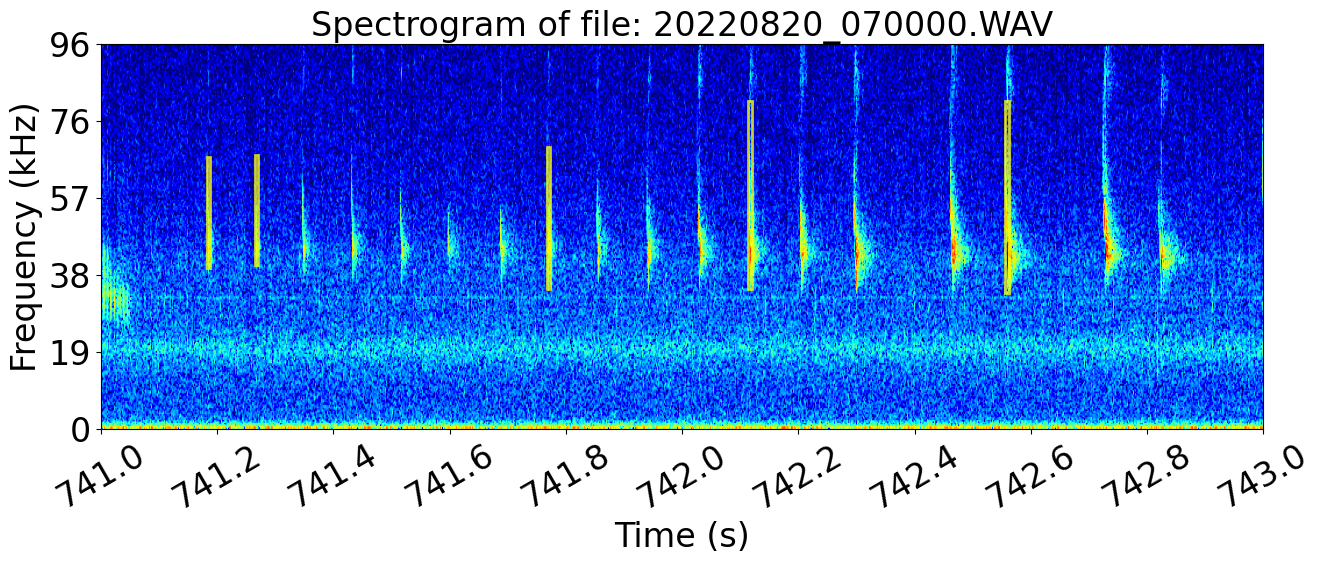

In [116]:
input_file1 = Path('../../duty-cycle-investigation/data/audiomoth_recordings/recover-20220822/Telephone/20220820_070000.WAV')

cfg = get_config()
cfg['input_audio'] = Path(input_file1)
cfg['tmp_dir'] = Path('../output/tmp')
cfg['output_dir'] = Path('../output_dir/recover-20210912/Foliage/')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = True

filename = input_file1.name.split('.')[0]
original_file_dets = pd.read_csv(f'../../duty-cycle-investigation/data/raw/Telephone/bd2__Telephone_{filename}.csv')
audio_data = sf.SoundFile(input_file1)
fs = audio_data.samplerate
start = 741
duration = 2
audio_data.seek(int(fs*start))
audio_seg = audio_data.read(int(fs*duration))

vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB
vmax = 20*np.log10(np.max(audio_seg)) + 0 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = input_file1
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['NFFT'] = 512
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax
spec_features['plot_title'] = f"Spectrogram of file: {audio_features['file_path'].name}"

window_cond = np.logical_and(original_file_dets['start_time'] > start, original_file_dets['end_time'] < (start+duration))
section_og_file_dets = original_file_dets.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, section_og_file_dets)

In [90]:
sr, audio_data2 = load_audio_file(input_file1, 1.0, 256000)
resamp_audio_seg = audio_data2[int(sr*start):int(sr*(start+duration))]

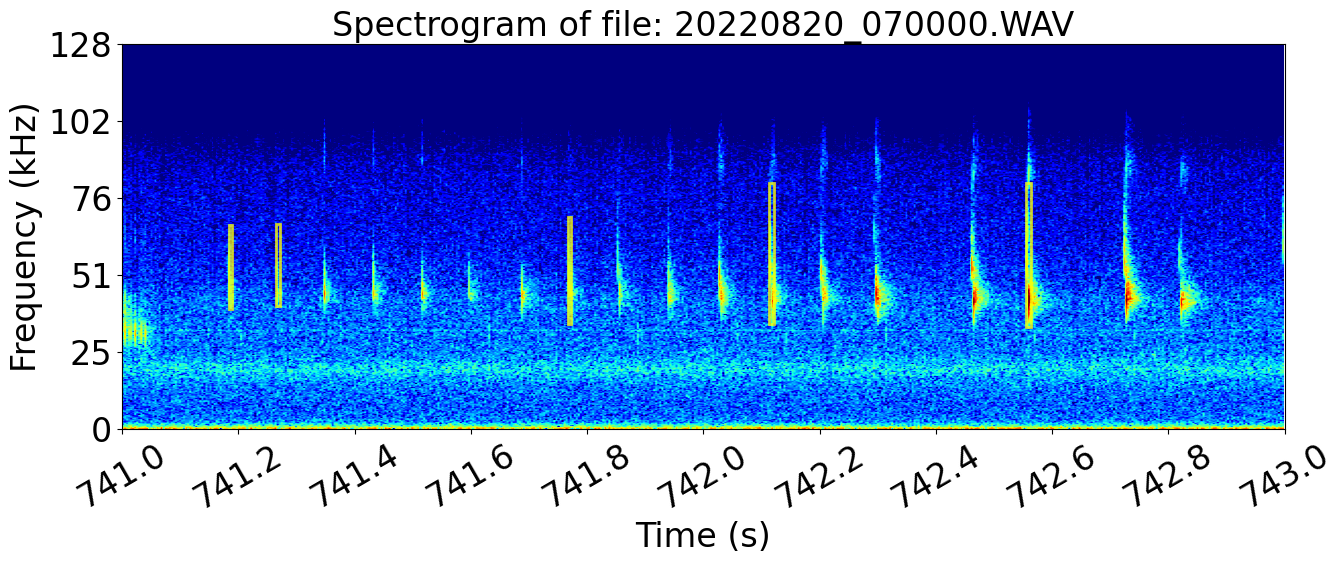

In [117]:
start = 741
duration = 2
resamp_audio_seg = audio_data2[int(sr*start):int(sr*(start+duration))]
vmin = 20*np.log10(np.max(resamp_audio_seg)) - 60 # hide anything below -rm_dB dB
vmax = 20*np.log10(np.max(resamp_audio_seg)) + 0 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = input_file1
audio_features['audio_seg'] = resamp_audio_seg
audio_features['sample_rate'] = 256000
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax
spec_features['plot_title'] = f"Spectrogram of file: {audio_features['file_path'].name}"

window_cond = np.logical_and(original_file_dets['start_time'] > start, original_file_dets['end_time'] < (start+duration))
section_og_file_dets = original_file_dets.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, section_og_file_dets)

In [172]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [173]:
net_params = torch.load('../src/models/bat_call_detector/batdetect2/models/Net2DFast_UK_same.pth.tar', map_location=device)

In [174]:
params = net_params['params']

In [175]:
params['device'] = device

In [176]:
args = dict()
args['chunk_size'] = 2

In [177]:
params['spec_scale']

'pcen'

In [178]:
params['denoise_spec_avg']

True

In [179]:
params['max_scale_spec']

False

In [97]:
def pad_audio(audio_raw, fs, ms, overlap_perc, resize_factor, divide_factor, fixed_width=None):
    # Adds zeros to the end of the raw data so that the generated sepctrogram
    # will be evenly divisible by `divide_factor`
    # Also deals with very short audio clips and fixed_width during training

    # This code could be clearer, clean up
    nfft = int(ms*fs)
    noverlap = int(overlap_perc*nfft)
    step = nfft - noverlap
    min_size = int(divide_factor*(1.0/resize_factor))
    spec_width = ((audio_raw.shape[0]-noverlap)//step)
    spec_width_rs = spec_width * resize_factor

    if fixed_width is not None and spec_width < fixed_width:
        # too small
        # used during training to ensure all the batches are the same size
        diff = fixed_width*step + noverlap - audio_raw.shape[0]
        audio_raw = np.hstack((audio_raw, np.zeros(diff, dtype=audio_raw.dtype)))

    elif fixed_width is not None and spec_width > fixed_width:
        # too big
        # used during training to ensure all the batches are the same size
        diff = fixed_width*step + noverlap - audio_raw.shape[0]
        audio_raw = audio_raw[:diff]

    elif spec_width_rs < min_size or (np.floor(spec_width_rs) % divide_factor) != 0:
        # need to be at least min_size
        div_amt = np.ceil(spec_width_rs / float(divide_factor))
        div_amt = np.maximum(1, div_amt)
        target_size = int(div_amt*divide_factor*(1.0/resize_factor))
        diff = target_size*step + noverlap - audio_raw.shape[0]
        audio_raw = np.hstack((audio_raw, np.zeros(diff, dtype=audio_raw.dtype)))

    return audio_raw

In [98]:
def gen_mag_spectrogram(x, fs, ms, overlap_perc):
    # Computes magnitude spectrogram by specifying time.

    x = x.astype(np.float32)
    nfft = int(ms*fs)
    noverlap = int(overlap_perc*nfft)

    # window data
    step = nfft - noverlap

    # compute spec
    spec, _ = librosa.core.spectrum._spectrogram(y=x, power=1, n_fft=nfft, hop_length=step, center=False)

    # remove DC component and flip vertical orientation
    spec = np.flipud(spec[1:, :])

    return spec.astype(np.float32)

def pcen(spec_cropped, sampling_rate):
    # TODO should be passing hop_length too i.e. step
    spec = librosa.pcen(spec_cropped * (2**31), sr=sampling_rate/10).astype(np.float32)
    return spec

def generate_spectrogram(audio, sampling_rate, params, return_spec_for_viz=False, check_spec_size=True):

    # generate spectrogram
    spec = gen_mag_spectrogram(audio, sampling_rate, params['fft_win_length'], params['fft_overlap'])

    # crop to min/max freq
    max_freq = round(params['max_freq']*params['fft_win_length'])
    min_freq = round(params['min_freq']*params['fft_win_length'])
    if spec.shape[0] < max_freq:
        freq_pad = max_freq - spec.shape[0]
        spec = np.vstack((np.zeros((freq_pad, spec.shape[1]), dtype=spec.dtype), spec))
    spec_cropped = spec[-max_freq:spec.shape[0]-min_freq, :]

    if params['spec_scale'] == 'log':
        log_scaling = 2.0 * (1.0 / sampling_rate) * (1.0/(np.abs(np.hanning(int(params['fft_win_length']*sampling_rate)))**2).sum())
        #log_scaling = (1.0 / sampling_rate)*0.1
        #log_scaling = (1.0 / sampling_rate)*10e4
        spec = np.log1p(log_scaling*spec_cropped)
    elif params['spec_scale'] == 'pcen':
        spec = pcen(spec_cropped, sampling_rate)
    elif params['spec_scale'] == 'none':
        pass

    if params['denoise_spec_avg']:
        spec = spec - np.mean(spec, 1)[:, np.newaxis]
        spec.clip(min=0, out=spec)

    if params['max_scale_spec']:
        spec = spec / (spec.max() + 10e-6)

    # needs to be divisible by specific factor - if not it should have been padded
    #if check_spec_size:
        #assert((int(spec.shape[0]*params['resize_factor']) % params['spec_divide_factor']) == 0)
        #assert((int(spec.shape[1]*params['resize_factor']) % params['spec_divide_factor']) == 0)

    # for visualization purposes - use log scaled spectrogram
    if return_spec_for_viz:
        log_scaling = 2.0 * (1.0 / sampling_rate) * (1.0/(np.abs(np.hanning(int(params['fft_win_length']*sampling_rate)))**2).sum())
        spec_for_viz = np.log1p(log_scaling*spec_cropped).astype(np.float32)
    else:
        spec_for_viz = None

    return spec, spec_for_viz

In [99]:
def compute_spectrogram(audio, sampling_rate, params, return_np=False):

    # pad audio so it is evenly divisible by downsampling factors
    duration = audio.shape[0] / float(sampling_rate)
    audio = pad_audio(audio, sampling_rate, params['fft_win_length'],
                         params['fft_overlap'], params['resize_factor'],
                         params['spec_divide_factor'])

    # generate spectrogram
    spec, _ = generate_spectrogram(audio, sampling_rate, params)

    # convert to pytorch
    spec = torch.from_numpy(spec).to(params['device'])
    spec = spec.unsqueeze(0).unsqueeze(0)

    # resize the spec
    rs = params['resize_factor']
    spec_op_shape = (int(params['spec_height']*rs), int(spec.shape[-1]*rs))
    spec = F.interpolate(spec, size=spec_op_shape, mode='bilinear', align_corners=False)

    if return_np:
        spec_np = spec[0,0,:].cpu().data.numpy()
    else:
        spec_np = None

    return duration, spec, spec_np

In [129]:
duration_full = resamp_audio_seg.shape[0] / float(sr)

return_np_spec = True

# loop through larger file and split into chunks
# TODO fix so that it overlaps correctly and takes care of duplicate detections at borders
num_chunks = int(np.ceil(duration_full/args['chunk_size']))
# for chunk_id in range(num_chunks):
chunk_id = 0

# chunk
chunk_time   = args['chunk_size']*chunk_id
chunk_length = int(sr*args['chunk_size'])
start_sample = chunk_id*chunk_length
end_sample   = np.minimum((chunk_id+1)*chunk_length, resamp_audio_seg.shape[0])
audio = resamp_audio_seg[start_sample:end_sample]
audio.shape

(512000,)

In [180]:
# load audio file and compute spectrogram
# duration, spec, spec_np = compute_spectrogram(audio, sr, params, return_np_spec)
# pad audio so it is evenly divisible by downsampling factors
duration = audio.shape[0] / float(sr)
audio = pad_audio(audio, sr, params['fft_win_length'],
                        params['fft_overlap'], params['resize_factor'],
                        params['spec_divide_factor'])


In [181]:
# generate spectrogram
spec, _ = generate_spectrogram(audio, sr, params, return_spec_for_viz=True)

In [183]:
spec.shape, _.shape

((220, 4032), (220, 4032))

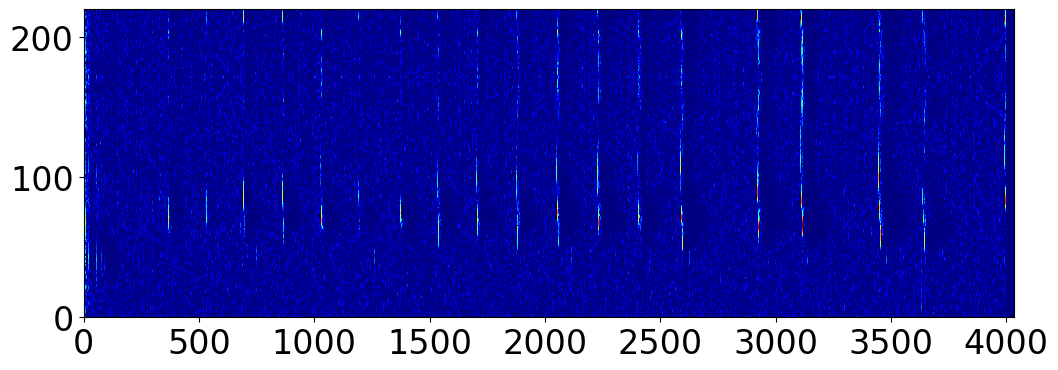

In [208]:
plt.figure(figsize=(12,4))
plt.pcolormesh((spec[::-1]),cmap='jet')
plt.show()

In [209]:

# convert to pytorch
spec = torch.from_numpy(spec).to(params['device'])
spec = spec.unsqueeze(0).unsqueeze(0)

# resize the spec
rs = params['resize_factor']
spec_op_shape = (int(params['spec_height']*rs), int(spec.shape[-1]*rs))
spec = F.interpolate(spec, size=spec_op_shape, mode='bilinear', align_corners=False)

spec_np = spec[0,0,:].cpu().data.numpy()

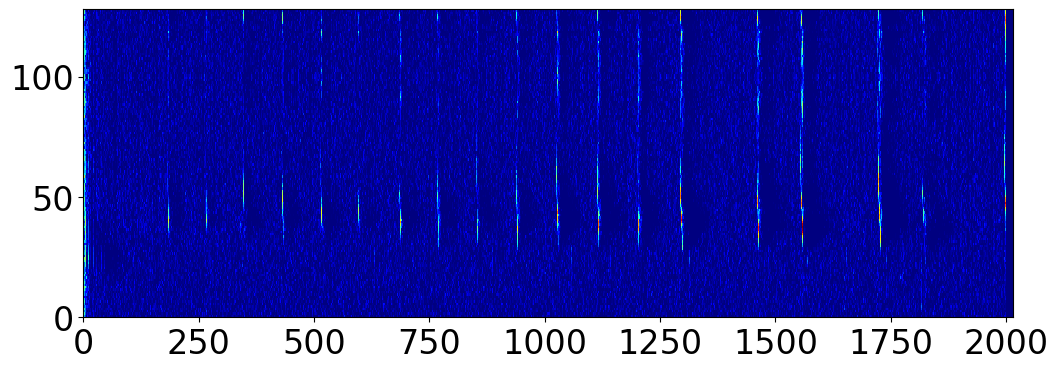

In [210]:
plt.figure(figsize=(12,4))
plt.pcolormesh((spec_np[::-1]),cmap='jet')
plt.show()

In [213]:
model = models.Net2DFast(params['num_filters'], num_classes=len(params['class_names']),
                                 emb_dim=params['emb_dim'], ip_height=params['ip_height'],
                                 resize_factor=params['resize_factor'])

In [214]:
model.load_state_dict(net_params['state_dict'])
model = model.to(params['device'])
model.eval()

Net2DFast(
  (conv_dn_0): ConvBlockDownCoordF(
    (conv): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_dn_1): ConvBlockDownCoordF(
    (conv): Conv2d(33, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_dn_2): ConvBlockDownCoordF(
    (conv): Conv2d(65, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_dn_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_dn_3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1d): Conv2d(256, 256, kernel_size=(16, 1), stride=(1, 1))
  (conv_1d_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a

In [272]:
# evaluate model
with torch.no_grad():
    outputs = model(spec, return_feats=True)

In [273]:
outputs.keys()

dict_keys(['pred_det', 'pred_size', 'pred_class', 'pred_class_un_norm', 'features'])

In [221]:
def x_coords_to_time(x_pos, sampling_rate, fft_win_length, fft_overlap):
    nfft = int(fft_win_length*sampling_rate)
    noverlap = int(fft_overlap*nfft)
    return ((x_pos*(nfft - noverlap)) + noverlap) / sampling_rate
    #return (1.0 - fft_overlap) * fft_win_length * (x_pos + 0.5)  # 0.5 is for center of temporal window


def overall_class_pred(det_prob, class_prob):
    weighted_pred = (class_prob*det_prob).sum(1)
    return weighted_pred / weighted_pred.sum()


def run_nms(outputs, params, sampling_rate):

    pred_det  = outputs['pred_det']   # probability of box
    pred_size = outputs['pred_size']  # box size

    pred_det_nms = non_max_suppression(pred_det, params['nms_kernel_size'])
    freq_rescale = (params['max_freq'] - params['min_freq']) /pred_det.shape[-2]

    # NOTE there will be small differences depending on which sampling rate is chosen
    # as we are choosing the same sampling rate for the entire batch
    duration = x_coords_to_time(pred_det.shape[-1], sampling_rate[0].item(),
                                params['fft_win_length'], params['fft_overlap'])
    top_k = int(duration * params['nms_top_k_per_sec'])
    scores, y_pos, x_pos = get_topk_scores(pred_det_nms, top_k)

    # loop over batch to save outputs
    preds = []
    feats = []
    for ii in range(pred_det_nms.shape[0]):
        # get valid indices
        inds_ord = torch.argsort(x_pos[ii, :])
        valid_inds = scores[ii, inds_ord] > params['detection_threshold']
        valid_inds = inds_ord[valid_inds]

        # create result dictionary
        pred = {}
        pred['det_probs']   = scores[ii, valid_inds]
        pred['x_pos']       = x_pos[ii, valid_inds]
        pred['y_pos']       = y_pos[ii, valid_inds]
        pred['bb_width']    = pred_size[ii, 0, pred['y_pos'], pred['x_pos']]
        pred['bb_height']   = pred_size[ii, 1, pred['y_pos'], pred['x_pos']]
        pred['start_times'] = x_coords_to_time(pred['x_pos'].float() / params['resize_factor'],
                                sampling_rate[ii].item(), params['fft_win_length'], params['fft_overlap'])
        pred['end_times']   = x_coords_to_time((pred['x_pos'].float()+pred['bb_width']) / params['resize_factor'],
                                sampling_rate[ii].item(), params['fft_win_length'], params['fft_overlap'])
        pred['low_freqs']   = (pred_size[ii].shape[1] - pred['y_pos'].float())*freq_rescale + params['min_freq']
        pred['high_freqs']  = pred['low_freqs'] + pred['bb_height']*freq_rescale

        # extract the per class votes
        if 'pred_class' in outputs:
            pred['class_probs'] = outputs['pred_class'][ii, :, y_pos[ii, valid_inds], x_pos[ii, valid_inds]]

        # extract the model features
        if 'features' in outputs:
            feat = outputs['features'][ii, :, y_pos[ii, valid_inds], x_pos[ii, valid_inds]].transpose(0, 1)
            feat = feat.cpu().numpy().astype(np.float32)
            feats.append(feat)

        # convert to numpy
        for kk in pred.keys():
            pred[kk] = pred[kk].cpu().numpy().astype(np.float32)
        preds.append(pred)

    return preds, feats


def non_max_suppression(heat, kernel_size):
    # kernel can be an int or list/tuple
    if type(kernel_size) is int:
        kernel_size_h = kernel_size
        kernel_size_w = kernel_size

    pad_h = (kernel_size_h - 1) // 2
    pad_w = (kernel_size_w - 1) // 2

    hmax = nn.functional.max_pool2d(heat, (kernel_size_h, kernel_size_w), stride=1, padding=(pad_h, pad_w))
    keep = (hmax == heat).float()

    return heat * keep


def get_topk_scores(scores, K):
    # expects input of size:  batch x 1 x height x width
    batch, _, height, width = scores.size()

    topk_scores, topk_inds = torch.topk(scores.view(batch, -1), K)
    topk_inds = topk_inds % (height * width)
    topk_ys   = torch.div(topk_inds, width, rounding_mode='floor').long()
    topk_xs   = (topk_inds % width).long()

    return topk_scores, topk_ys, topk_xs


In [274]:
predictions = []
spec_feats  = []
cnn_feats   = []
spec_slices = []

In [275]:
pred_nms, features = run_nms(outputs, params, np.array([float(sr)]))
pred_nms = pred_nms[0]
predictions.append(pred_nms)

In [276]:
def convert_int_to_freq(spec_ind, spec_height, min_freq, max_freq):
    spec_ind = spec_height-spec_ind
    return round((spec_ind / float(spec_height)) * (max_freq - min_freq) + min_freq, 2)

def extract_spec_slices(spec, pred_nms, params):
    """
    Extracts spectrogram slices from spectrogram based on detected call locations.
    """

    x_pos          = pred_nms['x_pos']
    y_pos          = pred_nms['y_pos']
    bb_width       = pred_nms['bb_width']
    bb_height      = pred_nms['bb_height']
    slices    = []

    # add 20% padding either side of call
    pad          = bb_width*0.2
    x_pos_pad    = x_pos - pad
    bb_width_pad = bb_width + 2*pad

    for ff in range(len(pred_nms['det_probs'])):
        x_start = int(np.maximum(0, x_pos_pad[ff]))
        x_end   = int(np.minimum(spec.shape[1]-1, np.round(x_pos_pad[ff] + bb_width_pad[ff])))
        slices.append(spec[:, x_start:x_end].astype(np.float16))
    return slices


def get_feature_names():
    feature_names  = ['duration', 'low_freq_bb', 'high_freq_bb', 'bandwidth',
                     'max_power_bb', 'max_power', 'max_power_first',
                     'max_power_second', 'call_interval']
    return feature_names


def get_feats(spec, pred_nms, params):
    """
    Extracts features from spectrogram based on detected call locations.
    Condsider re-extracting spectrogram for this to get better temporal resolution.

    For more possible features check out:
    https://github.com/YvesBas/Tadarida-D/blob/master/Manual_Tadarida-D.odt
    """

    x_pos          = pred_nms['x_pos']
    y_pos          = pred_nms['y_pos']
    bb_width       = pred_nms['bb_width']
    bb_height      = pred_nms['bb_height']

    feature_names  = get_feature_names()
    num_detections = len(pred_nms['det_probs'])
    features       = np.ones((num_detections, len(feature_names)), dtype=np.float32)*-1

    for ff in range(num_detections):
        x_start = int(np.maximum(0, x_pos[ff]))
        x_end   = int(np.minimum(spec.shape[1]-1, np.round(x_pos[ff] + bb_width[ff])))
        # y low is the lowest freq but it will have a higher value due to array starting at 0 at top
        y_low   = int(np.minimum(spec.shape[0]-1, y_pos[ff]))
        y_high  = int(np.maximum(0, np.round(y_pos[ff] - bb_height[ff])))
        spec_slice = spec[:, x_start:x_end]

        if spec_slice.shape[1] > 1:
            features[ff, 0] = round(pred_nms['end_times'][ff] - pred_nms['start_times'][ff], 5)
            features[ff, 1] = int(pred_nms['low_freqs'][ff])
            features[ff, 2] = int(pred_nms['high_freqs'][ff])
            features[ff, 3] = int(pred_nms['high_freqs'][ff] - pred_nms['low_freqs'][ff])
            features[ff, 4] = int(convert_int_to_freq(y_high+spec_slice[y_high:y_low, :].sum(1).argmax(),
                                       spec.shape[0], params['min_freq'], params['max_freq']))
            features[ff, 5] = int(convert_int_to_freq(spec_slice.sum(1).argmax(),
                                       spec.shape[0], params['min_freq'], params['max_freq']))
            hlf_val = spec_slice.shape[1]//2

            features[ff, 6] = int(convert_int_to_freq(spec_slice[:, :hlf_val].sum(1).argmax(),
                                       spec.shape[0], params['min_freq'], params['max_freq']))
            features[ff, 7] = int(convert_int_to_freq(spec_slice[:, hlf_val:].sum(1).argmax(),
                                       spec.shape[0], params['min_freq'], params['max_freq']))

            if ff > 0:
                features[ff, 8] = round(pred_nms['start_times'][ff] - pred_nms['start_times'][ff-1], 5)

    return features


In [277]:
def merge_results(predictions, spec_feats, cnn_feats, spec_slices):

    predictions_m = {}
    num_preds = np.sum([len(pp['det_probs']) for pp in predictions])

    if num_preds > 0:
        for kk in predictions[0].keys():
            predictions_m[kk] = np.hstack([pp[kk] for pp in predictions if pp['det_probs'].shape[0] > 0])
    else:
        # hack in case where no detected calls as we need some of the key names in dict
        predictions_m = predictions[0]

    if len(spec_feats) > 0:
        spec_feats = np.vstack(spec_feats)
    if len(cnn_feats) > 0:
        cnn_feats = np.vstack(cnn_feats)
    return predictions_m, spec_feats, cnn_feats, spec_slices


def convert_results(file_id, time_exp, duration, params, predictions, spec_feats, cnn_feats, spec_slices):

    # create a single dictionary - this is the format used by the annotation tool
    pred_dict = {}
    pred_dict['id'] = file_id
    pred_dict['annotated'] = False
    pred_dict['issues'] = False
    pred_dict['notes'] = 'Automatically generated.'
    pred_dict['time_exp'] = time_exp
    pred_dict['duration'] = round(duration, 4)
    pred_dict['annotation'] = []

    class_prob_best = predictions['class_probs'].max(0)
    class_ind_best  = predictions['class_probs'].argmax(0)
    class_overall   = overall_class_pred(predictions['det_probs'], predictions['class_probs'])
    pred_dict['class_name'] = params['class_names'][np.argmax(class_overall)]

    for ii in range(predictions['det_probs'].shape[0]):
        res = {}
        res['start_time'] = round(float(predictions['start_times'][ii]), 4)
        res['end_time']   = round(float(predictions['end_times'][ii]), 4)
        res['low_freq']   = int(predictions['low_freqs'][ii])
        res['high_freq']  = int(predictions['high_freqs'][ii])
        res['class']      = str(params['class_names'][int(class_ind_best[ii])])
        res['class_prob'] = round(float(class_prob_best[ii]), 3)
        res['det_prob']   = round(float(predictions['det_probs'][ii]), 3)
        res['individual'] = '-1'
        res['event']      = 'Echolocation'
        pred_dict['annotation'].append(res)

    # combine into final results dictionary
    results = {}
    results['pred_dict'] = pred_dict
    if len(spec_feats) > 0:
        results['spec_feats'] = spec_feats
        results['spec_feat_names'] = get_feature_names()
    if len(cnn_feats) > 0:
        results['cnn_feats'] = cnn_feats
        results['cnn_feat_names'] = [str(ii) for ii in range(cnn_feats.shape[1])]
    if len(spec_slices) > 0:
        results['spec_slices'] = spec_slices

    return results

In [278]:
# extract features - if there are any calls detected
if (pred_nms['det_probs'].shape[0] > 0):
    cnn_feats.append(features[0])

In [279]:
file_id = input_file1.name
predictions, spec_feats, cnn_feats, spec_slices =\
            merge_results(predictions, spec_feats, cnn_feats, spec_slices)

In [280]:
predictions

{'det_probs': array([0.07513475, 0.02316141, 0.03020354, 0.11341766, 0.0255697 ,
        0.03942514, 0.02197235, 0.02564642, 0.0361989 , 0.03531411,
        0.03618321, 0.02642381, 0.216135  , 0.02298526, 0.02347045,
        0.02571901, 0.02410477, 0.02155418, 0.02454677, 0.02518522,
        0.04632333, 0.03864864, 0.02227062, 0.03401265, 0.0221709 ,
        0.02292309, 0.17384738, 0.02927817, 0.47934186, 0.03713046,
        0.03913569, 0.02195456, 0.04031398, 0.02260266, 0.0234526 ,
        0.0826961 , 0.5099867 , 0.02807157, 0.02338283, 0.04119825,
        0.02718123, 0.38464433, 0.03254079, 0.07731071, 0.02397114,
        0.04846437, 0.02132689, 0.02363582, 0.02289133, 0.02130682,
        0.02669437, 0.0212697 , 0.02568858, 0.41191718, 0.03832602,
        0.03506294, 0.02210747, 0.030658  , 0.02203787, 0.02331706,
        0.4364999 , 0.02630888, 0.07183371, 0.07517198, 0.03032541,
        0.4122894 , 0.02217499, 0.05683087, 0.02273194, 0.02201605,
        0.02421118, 0.02383985, 0.0

In [281]:
# results = convert_results(file_id, 1.0, duration_full, params,
#                             predictions, spec_feats, cnn_feats, spec_slices)

# create a single dictionary - this is the format used by the annotation tool
pred_dict = {}
pred_dict['id'] = file_id
pred_dict['annotated'] = False
pred_dict['issues'] = False
pred_dict['notes'] = 'Automatically generated.'
pred_dict['time_exp'] = 1.0
pred_dict['duration'] = round(duration, 4)
pred_dict['annotation'] = []

class_prob_best = predictions['class_probs'].max(0)
class_ind_best  = predictions['class_probs'].argmax(0)

In [282]:
class_overall   = overall_class_pred(predictions['det_probs'], predictions['class_probs'])
class_overall

array([7.8178407e-04, 2.2362033e-03, 8.9209096e-04, 3.0064594e-02,
       1.0190650e-01, 9.1376491e-02, 8.7585906e-03, 1.2940338e-03,
       9.0984261e-04, 2.6185895e-04, 1.3063038e-02, 1.2650092e-02,
       3.8062281e-03, 1.5075480e-03, 1.0429510e-03, 1.3462441e-03,
       3.5900166e-03, 7.2451186e-01], dtype=float32)

In [286]:
def process_file(audio_file, model, params, args, time_exp=None, top_n=5, return_raw_preds=False, max_duration=False):

    # store temporary results here
    predictions = []
    spec_feats  = []
    cnn_feats   = []
    spec_slices = []

    # get time expansion  factor
    if time_exp is None:
        time_exp = args['time_expansion_factor']

    params['detection_threshold'] = args['detection_threshold']

    # load audio file
    sampling_rate, audio_full = load_audio_file(audio_file, time_exp,
                                   params['target_samp_rate'], params['scale_raw_audio'])

    # clipping maximum duration
    if max_duration is not False:
        max_duration = np.minimum(int(sampling_rate*max_duration), audio_full.shape[0])
        audio_full = audio_full[:max_duration]
    
    duration_full = audio_full.shape[0] / float(sampling_rate)

    return_np_spec = args['spec_features'] or args['spec_slices']

    # loop through larger file and split into chunks
    # TODO fix so that it overlaps correctly and takes care of duplicate detections at borders
    num_chunks = int(np.ceil(duration_full/args['chunk_size']))
    for chunk_id in range(num_chunks):

        # chunk
        chunk_time   = args['chunk_size']*chunk_id
        chunk_length = int(sampling_rate*args['chunk_size'])
        start_sample = chunk_id*chunk_length
        end_sample   = np.minimum((chunk_id+1)*chunk_length, audio_full.shape[0])
        audio = audio_full[start_sample:end_sample]

        # load audio file and compute spectrogram
        duration, spec, spec_np = compute_spectrogram(audio, sampling_rate, params, return_np_spec)

        # evaluate model
        with torch.no_grad():
            outputs = model(spec, return_feats=args['cnn_features'])

        # run non-max suppression
        pred_nms, features = run_nms(outputs, params, np.array([float(sampling_rate)]))
        pred_nms = pred_nms[0]
        pred_nms['start_times'] += chunk_time
        pred_nms['end_times'] += chunk_time

        # if we have a background class
        if pred_nms['class_probs'].shape[0] > len(params['class_names']):
            pred_nms['class_probs'] = pred_nms['class_probs'][:-1, :]

        predictions.append(pred_nms)

        # extract features - if there are any calls detected
        if (pred_nms['det_probs'].shape[0] > 0):
            if args['spec_features']:
                spec_feats.append(get_feats(spec_np, pred_nms, params))

            if args['cnn_features']:
                cnn_feats.append(features[0])

            if args['spec_slices']:
                spec_slices.extend(extract_spec_slices(spec_np, pred_nms, params))

    # convert the predictions into output dictionary
    file_id = audio_file.name
    predictions, spec_feats, cnn_feats, spec_slices =\
              merge_results(predictions, spec_feats, cnn_feats, spec_slices)
    results = convert_results(file_id, time_exp, duration_full, params,
                              predictions, spec_feats, cnn_feats, spec_slices)

    # summarize results
    if not args['quiet']:
        num_detections = len(results['pred_dict']['annotation'])
        print('{}'.format(num_detections) + ' call(s) detected above the threshold.')

    # print results for top n classes
    if not args['quiet'] and (num_detections > 0):
        class_overall = overall_class_pred(predictions['det_probs'], predictions['class_probs'])
        print('species name'.ljust(30) + 'probablity present')
        for cc in np.argsort(class_overall)[::-1][:top_n]:
            print(params['class_names'][cc].ljust(30) + str(round(class_overall[cc], 3)))

    if return_raw_preds:
        return predictions
    else:
        return results


In [287]:
model_output = process_file(
            audio_file=input_file1, 
            model=model, 
            params=params, 
            args= {
                'detection_threshold': 0.5,
                'spec_slices': False,
                'chunk_size': 2,
                'quiet': False,
                'spec_features' : False,
                'cnn_features': True,
            },
            time_exp=1.0,
        )

4013 call(s) detected above the threshold.
species name                  probablity present
Pipistrellus pipistrellus     0.378
Pipistrellus nathusii         0.292
Myotis alcathoe               0.119
Myotis daubentonii            0.066
Myotis brandtii               0.058


In [ ]:
model_output

In [ ]:
pred_dict['class_name'] = params['class_names'][np.argmax(class_overall)]

for ii in range(predictions['det_probs'].shape[0]):
    res = {}
    res['start_time'] = round(float(predictions['start_times'][ii]), 4)
    res['end_time']   = round(float(predictions['end_times'][ii]), 4)
    res['low_freq']   = int(predictions['low_freqs'][ii])
    res['high_freq']  = int(predictions['high_freqs'][ii])
    res['class']      = str(params['class_names'][int(class_ind_best[ii])])
    res['class_prob'] = round(float(class_prob_best[ii]), 3)
    res['det_prob']   = round(float(predictions['det_probs'][ii]), 3)
    res['individual'] = '-1'
    res['event']      = 'Echolocation'
    pred_dict['annotation'].append(res)

# combine into final results dictionary
results = {}
results['pred_dict'] = pred_dict
if len(spec_feats) > 0:
    results['spec_feats'] = spec_feats
    results['spec_feat_names'] = get_feature_names()
if len(cnn_feats) > 0:
    results['cnn_feats'] = cnn_feats
    results['cnn_feat_names'] = [str(ii) for ii in range(cnn_feats.shape[1])]
if len(spec_slices) > 0:
    results['spec_slices'] = spec_slices